<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Reddit

# Contents:
- [Model and Evaluation](#Model-and-Evaluation)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

In [2]:
keto_vegan = pd.read_csv('data/keto_vegan.csv')

In [3]:
keto_vegan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     6471 non-null   object 
 1   title         6466 non-null   object 
 2   selftext      6469 non-null   object 
 3   created_utc   6466 non-null   float64
 4   title_posts   6466 non-null   object 
 5   title_length  6466 non-null   float64
 6   post_length   6466 non-null   float64
dtypes: float64(3), object(4)
memory usage: 354.0+ KB


In [4]:
keto_vegan.dropna(inplace=True)

When loading the data, random values got inserted that created null values. I was able to drop the null values without disrupting the integrity of my data

# Model and Evaluation 

In [7]:
X = keto_vegan['title_posts']
y = keto_vegan['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)
X_train.shape, X_test.shape

((4847,), (1616,))

In [8]:
y_train.shape, y_test.shape

((4847,), (1616,))

#### Baseline Model

In [9]:
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_test, y_test)

0.5321782178217822

- **Baseline accuracy score is 53.21%.**
- **Success will be defined as anything above this score and the accurate classification of the two slogans:**
- **Vegan**: "I know it may not seem like it but we love animals too"
- **Keto**: "Healthy fats, quality protein, and just the right amount of carbs to keep you energized throughout the day"

In [10]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(w) for w in word_tokenize(doc)]

Function that iterates through a document and implements a more complex stemming process that can derive the root of a word (ex. best and better) 

#### Logistic Regression

In [11]:
pipe = make_pipeline(CountVectorizer(strip_accents='unicode', stop_words='english', tokenizer=lemma_tokenizer, min_df=2, ngram_range=(1,2)),LogisticRegression(max_iter=10_000)) 
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(0.9997936868165875, 0.9603960396039604)

Accuracy score of 96.04%. This beats the baseline accuracy rate. Model is performing ideally but slightly overfit

In [12]:
pipe.predict(["I know it may not seem like it but we love animals too"]), pipe.predict(["Healthy fats, quality protein, and just the right amount of carbs to keep you energized throughout the day"])

(array(['vegan'], dtype=object), array(['keto'], dtype=object))

Model is able to classify the slogans between the correct classes

In [47]:
pipe.predict_proba(["I know it may not seem like it but we love animals too"]), pipe.predict_proba(["Healthy fats, quality protein, and just the right amount of carbs to keep you energized throughout the day"])

(array([[0.26468692, 0.73531308]]), array([[0.91911639, 0.08088361]]))

- The vegan slogan is likely to get classified in the vegan class 73.53% of the time
- The keto slogan is likely to get classified in the keto class 91.91% of the time 

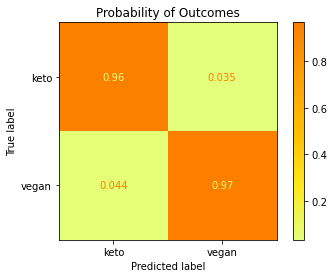

In [45]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Wistia', normalize='pred')
plt.title('Probability of Outcomes')
plt.savefig('figures/LogReg_Confusion.png'); 

- Positive class = vegan
- Shows vegan is being slightly, more accurately predicted at 97% in comparison to keto at 96%
- Keto and vegan incorrectly predicted 4.4% and 3.5%, respectively 

In [38]:
coefs_vegan = pd.DataFrame(list(zip(pipe.named_steps['countvectorizer'].get_feature_names_out(), np.exp(pipe.named_steps['logisticregression'].coef_[0])))).set_index(0)
coefs_vegan.rename(columns={1: 'coefs'}, inplace=True)
coefs_vegan.sort_values(by='coefs',ascending=False)[:15]

,coefs
0,
vegan,25.607408
animal,3.945826
crossfit,2.976771
veganism,2.718524
tofu,2.351902
meat,2.161673
view,2.024771
poll ],1.969024
industry,1.967286


- These coefficients show how likely each of these features will be classified in the vegan (positive class) subreddit. 
- The coefficients listed show the features that are the most likely to appear in a vegan subreddit
- Ex. For every instance of the word 'vegan', the title and post is 25.61 times as likely to appear in a vegan subreddit.

In [33]:
coefs_keto = pd.DataFrame(list(zip(pipe.named_steps['countvectorizer'].get_feature_names_out(), np.exp(pipe.named_steps['logisticregression'].coef_[0])))).set_index(0)
coefs_keto.rename(columns={1: 'coefs'},inplace=True)
np.abs(coefs_keto).sort_values(by='coefs')[:10]

,coefs
0,
keto,0.035338
carbs,0.274527
carb,0.293669
ketosis,0.413263
scale,0.486040
electrolyte,0.512094
macro,0.520337
weight,0.531218
sweetener,0.533541


- These coefficients show how likely each of these features will be classified in the vegan (positive class) subreddit. 
- The coefficients listed show the features that are the most likely to appear in a **keto** subreddit
- Ex. For every instance of the word 'keto', the title and post is 3.53 times as likely to appear in a vegan subreddit and 96.47 times as likely to appear in a keto subreddit

In [17]:
coefs_total = pd.DataFrame(list(zip(pipe.named_steps['countvectorizer'].get_feature_names_out(), np.expm1(pipe.named_steps['logisticregression'].coef_[0])))).set_index(0)
coefs_total.rename(columns={1: 'coefs'},inplace=True)
np.abs(coefs_total).sort_values(by='coefs',ascending=False)[:10]

,coefs
0,
vegan,24.607408
animal,2.945826
crossfit,1.976771
veganism,1.718524
tofu,1.351902
meat,1.161673
view,1.024771
poll ],0.969024
industry,0.967286


These are the strongest coefficients overall. Although keto had a higher frequency in titles and posts, it was more likely for the model to classify text with vegan into the vegan (positive) class. 

#### Random Forest Classifier

In [18]:
pipe2 = make_pipeline(CountVectorizer(strip_accents='unicode',stop_words='english', min_df=2),RandomForestClassifier(max_depth=10))
pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.962657313802352, 0.948019801980198)

Accuracy score of 94.37%. This beats the baseline accuracy rate. Model is performing ideally but slightly overfit

In [19]:
pipe2.predict(["I know it may not seem like it but we love animals too"]), pipe2.predict(["High fat, moderate protein, just the right amount of carbs to keep you energixed throughout the day"])

(array(['vegan'], dtype=object), array(['keto'], dtype=object))

Model is able to classify the slogans between the correct classes

In [27]:
pipe2.predict_proba(["I know it may not seem like it but we love animals too"]), pipe2.predict_proba(["Healthy fats, quality protein, and just the right amount of carbs to keep you energized throughout the day"])

(array([[0.45299189, 0.54700811]]), array([[0.57427759, 0.42572241]]))

- The vegan slogan is likely to get classified in the vegan class 54.70% of the time
- The keto slogan is likely to get classified in the keto class 57.43% of the time 

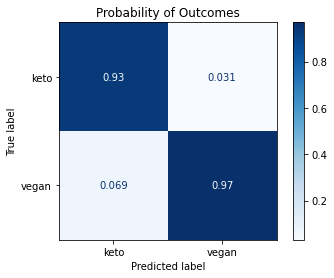

In [42]:
ConfusionMatrixDisplay.from_estimator(pipe2,X_test, y_test, cmap='Blues', normalize='pred')
plt.title('Probability of Outcomes')
plt.savefig('figures/RandomForest_Confusion.png');

- Positive class = vegan
- Shows vegan is being more accurately predicted at 97% in comparison to keto at 93%
- Keto and vegan incorrectly predicted 6.9% and 3.1%, respectively 

#### KNN

In [21]:
pipe3 = make_pipeline(CountVectorizer(strip_accents='unicode',stop_words='english',min_df=2, tokenizer=lemma_tokenizer),KNeighborsClassifier(n_neighbors=5))
pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train), pipe3.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(0.8803383536207964, 0.817450495049505)

Accuracy score of 81.75%. This beats the baseline accuracy rate. Model is performing ideally but is inferior to the other models and classifiers; also overfit 

In [22]:
pipe3.predict(["I know it may not seem like it but we love animals too"]), pipe3.predict(["High fat, moderate protein, just the right amount of carbs to keep you energixed throughout the day"])

(array(['vegan'], dtype=object), array(['vegan'], dtype=object))

Model is **not** able to classify the slogans between the correct classes

In [31]:
pipe3.predict_proba(["I know it may not seem like it but we love animals too"]), pipe3.predict_proba(["Healthy fats, quality protein, and just the right amount of carbs to keep you energized throughout the day"])

(array([[0.2, 0.8]]), array([[0.2, 0.8]]))

- The vegan slogan is likely to get classified in the vegan class 80% of the time
- The keto slogan is likely to get classified in the keto class 20% of the time 

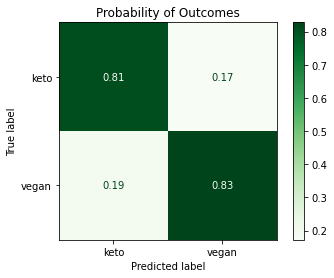

In [43]:
ConfusionMatrixDisplay.from_estimator(pipe3,X_test, y_test, cmap='Greens',normalize='pred')
plt.title('Probability of Outcomes')
plt.savefig('figures/KNN_Confusion.png');

- Positive class = vegan
- Shows vegan is being slightly, more accurately predicted at 83% in comparison to keto at 81%
- Keto and vegan incorrectly predicted 19% and 17%, respectively 

#### ADA BOOST

In [24]:
pipe4 = make_pipeline(CountVectorizer(strip_accents='unicode',stop_words='english',min_df=2, tokenizer=lemma_tokenizer),AdaBoostClassifier(random_state=42, n_estimators=200))
pipe4.fit(X_train, y_train)
pipe4.score(X_train, y_train), pipe4.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(0.9993810604497627, 0.9461633663366337)

Accuracy score of 94.62%. This beats the baseline accuracy rate. Model is performing ideally but is slightly overfit

In [25]:
pipe4.predict(["I know it may not seem like it but we love animals too"]), pipe4.predict(["High fat, moderate protein, just the right amount of carbs to keep you energixed throughout the day"])

(array(['vegan'], dtype=object), array(['keto'], dtype=object))

Model is able to classify the slogans between the correct classes

In [30]:
pipe4.predict_proba(["I know it may not seem like it but we love animals too"]), pipe4.predict_proba(["Healthy fats, quality protein, and just the right amount of carbs to keep you energized throughout the day"])

(array([[0.49617937, 0.50382063]]), array([[0.5105871, 0.4894129]]))

- The vegan slogan is likely to get classified in the vegan class 50.38% of the time
- The keto slogan is likely to get classified in the keto class 51.06% of the time 

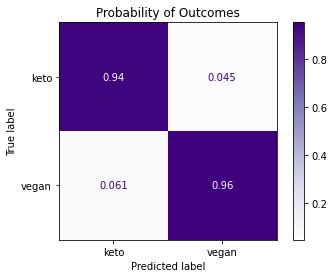

In [44]:
ConfusionMatrixDisplay.from_estimator(pipe4,X_test, y_test, cmap='Purples', normalize='pred')
plt.title('Probability of Outcomes')
plt.savefig('figures/ADABoost_Confusion.png');

- Positive class = vegan
- Shows vegan is being slightly, more accurately predicted at 96% in comparison to keto at 94%
- Keto and vegan incorrectly predicted 6.1% and 4.5%, respectively 

# Conclusion and Recommendations

Although there were a few models that performed successfuly, the CountVectorizer + Logistic Regression model produced the highest accuracy score of 96% with proper classification of the given slogans. HelloFrezh should utilize some of the top 10 features from this model that show a strong correlation with each class in their final marketing plan. Some of these words include keto, carbs, vegan, and animal. When developing further slogan,s they should test whether their slogan would classify with either keto or vegan subreddits to ensure the language aligns with the community. If they wish to improve the model, they can do further data cleaning such as removing urls or polls, use a RandomSearchCV or GridSearchCV to tune hyperparameters, and test other models such as Naive Bayes or create an ensemble. 